# PS model example
This notebook shows how one can construct a full model of the PS using PyWIT, assuming the PS_data directory shown below.

![title](img/ps_data_directory.png)

In [1]:
from pathlib import Path
from os import listdir

import numpy as np
from pywit.interface import *
from pywit.element import Element
from pywit.model import Model
from pywit.plot import generate_contribution_plots, plot_total_impedance_and_wake, plot_component_impedance
from pywit.utilities import create_resonator_element
from pandas import read_excel

In [2]:
# Obtain the path of the PS_data directory
data_folder = Path.home().joinpath('PS_data')

# Load data about the lengths and beta functions for various elements
params = np.load(data_folder.joinpath('elements_dict.npy'),
                 allow_pickle=True, encoding='latin1').item()

# Read the shunt impedances, resonance frequencies and quality factors for 44 resonators from an excel file
d = read_excel(data_folder.joinpath('kickers_resonators.xlsx'), header = [0,1])

# The names of all of the kickers in the excel file
names = d[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')]

# Establishes a default length as well as default beta function in x and y directions
default_length = 1
default_beta_x = 17.00884579219969
default_beta_y = 16.83582453350477

# Defines an empty list of elements which we will populate with resonators, beam pipes and other elements
elements = []

# Defines a useful function for extracting the parameters corresponding to a given device name from the 
# params dictionary
def get_parameters(name):
    output = [default_length, default_beta_x, default_beta_y]
    
    for k, v in params.items():
        if k in name:
            found = True
            for i, key in enumerate(('L', 'betax', 'betay')):
                if v[key].shape[0] != 0:
                    output[i] = v[key][0]
            break
            
    if output[0] <= 0:
        output[0] = default_length
    
    return output

In [3]:
# Iterates through the quite complex pandas dataframe to construct resonators
for i, name in enumerate(names):
    for n in range(1, 5):
        
        # Defines three dictionaries which will hold the shunt impedances, quality factors and resonance frequencies
        # corresponding to each component for a single resonator
        rs, qs, fs = dict(), dict(), dict()
        
        # Populates the three dictionaries for each of the four transverse components (dipolar and quadripolar)
        for col_name, type_string in zip(('Zdipx', 'Zdipy', 'Zquadx', 'Zquady'),
                                         ('x1000', 'y0100', 'x0010', 'y0001')):
            r, q, f = [d[col_name][sub_header][i] for sub_header in (f'Rt{n} (10^4 Ohm)', f'Q{n}', f'fres{n} (GHz)')]
            for dictionary, value in zip((rs, qs, fs), (r, q, f)):
                if not np.isnan(value):
                    dictionary[type_string] = value
              
        # Scales the values in the excel files into SI-units
        for k in rs:
            rs[k] *= 1e4            
        for k in fs:
            fs[k] *= 1e9
        
        # Gets the length and beta functions corresponding to the name of the kicker
        l, beta_x, beta_y = get_parameters(name)
        
        # Creates a resonator element using the parameters we have defined
        resonator = create_resonator_element(l, beta_x, beta_y, rs, qs, fs)
        
        # Tags the resonator as part of a kicker-element (each kicker is modelled using 3-4 resonators in this case)
        resonator.tag = 'kicker'
         
        # Appends the resonator to our list of elements
        elements.append(resonator)

# The 'elements'-list now contains 44 elements

In [4]:
# Obtains lists of all the names of the wake and impedance data files
impedance_folder = data_folder.joinpath('Impedances').joinpath('Transverse')
wake_folder = data_folder.joinpath('Wakes').joinpath('Transverse')  
impedance_files = listdir(impedance_folder)
wake_files = listdir(wake_folder)

# Defines the transverse yokoya factors for the beam pipe
yokoya_factors = {'x1000': 0.4581244311136996, 
                  'y0100': 0.8380004848982937, 
                  'x0010': -0.38110390779352443, 
                  'y0001': 0.3842568725166634}

# Iterates through all of the filenames
for filename in impedance_files:
    # Filenames containing BFA or KFA correspond to kickers, which have already been dealt with,
    # so they are skipped
    if 'BFA' in filename or 'KFA' in filename:
        continue
        
    # Each impedance file has a corresponding wake file
    wake_filename = filename[:-3] + 'wake'
    
    # Uses PyWIT functions to load the impedance and wake data files
    impedance_components = load_transverse_impedance_datafile(impedance_folder.joinpath(filename))
    wake_components = load_transverse_wake_datafile(wake_folder.joinpath(wake_filename))
    
    # Joins these components together in a single list
    all_components = list(impedance_components + wake_components)
    
    # Gets the length and beta functions of the element
    length, beta_x, beta_y = get_parameters(filename)
    
    # Creates an element using the parameters and the list of components, and tags it as 'other'
    element = Element(length, beta_x, beta_y, all_components, tag='other')
    
    # Appends the element to the 'elements'-list
    elements.append(element)
    
    
# There are now 72 elements in the 'elements'-list
    

# Creates lists of component-recipes using two sets of 10 IW2D files (wake and impedance for 5 separate components)
recipes1 = import_data_iw2d(data_folder.joinpath('IW2D'), '_PS_InconelX750_round_HG35.0mm_precise')
recipes2 = import_data_iw2d(data_folder.joinpath('IW2D'), '_PS_ss316LN_round_HG35.0mm_precise')

# Creates two lists of components from these recipes
components1 = [create_component_from_data(*recipe, relativistic_gamma=27.7513022027) for recipe in recipes1]
components2 = [create_component_from_data(*recipe, relativistic_gamma=27.7513022027) for recipe in recipes2]

# Extracts the dipolar x-component of the impedance and wake, respectively, for each of the two beam pipe elements
dipolar_x_1_imp = [1.0 * c for c in components1 if c.get_shorthand_type() == 'x1000' and c.impedance][0]
dipolar_x_1_wake = [1.0 * c for c in components1 if c.get_shorthand_type() == 'x1000' and c.wake][0]
dipolar_x_2_imp = [1.0 * c for c in components2 if c.get_shorthand_type() == 'x1000' and c.impedance][0]
dipolar_x_2_wake = [1.0 * c for c in components2 if c.get_shorthand_type() == 'x1000' and c.wake][0]

# Creates two empty lists to hold the components resulting from scaling the dipolar x-component by the yokoya
# factors
scaled_components1, scaled_components2 = [], []

# Scales the components in components1 by their corresponding yokoya-factors and adds them to scaled_components1
for comp in components1:
    if comp.get_shorthand_type() == 'z0000':
        scaled_components1.append(comp)
        continue
    if comp.impedance:
        scaled_comp = yokoya_factors[comp.get_shorthand_type()] * dipolar_x_1_imp
    else:
        scaled_comp = yokoya_factors[comp.get_shorthand_type()] * dipolar_x_1_wake
    scaled_comp.plane = comp.plane
    scaled_comp.source_exponents, scaled_comp.test_exponents = comp.source_exponents, comp.test_exponents
    scaled_comp.power_x, scaled_comp.power_y = comp.power_x, comp.power_y
    scaled_components1.append(scaled_comp)
    

# Scales the components in components2 by their corresponding yokoya-factors and adds them to scaled_components2
for comp in components2:
    if comp.get_shorthand_type() == 'z0000':
        scaled_components2.append(comp)
        continue
    if comp.impedance:
        scaled_comp = yokoya_factors[comp.get_shorthand_type()] * dipolar_x_2_imp
    else:
        scaled_comp = yokoya_factors[comp.get_shorthand_type()] * dipolar_x_2_wake
    scaled_comp.plane = comp.plane
    scaled_comp.source_exponents, scaled_comp.test_exponents = comp.source_exponents, comp.test_exponents
    scaled_comp.power_x, scaled_comp.power_y = comp.power_x, comp.power_y
    scaled_components2.append(scaled_comp)

# Creates two elements corresponding to 1m of beam pipe in inconel and stainless steel, respectively 
resistive_wall1 = Element(1, 17.00884579219969, 16.83582453350477, scaled_components1)
resistive_wall2 = Element(1, 17.00884579219969, 16.83582453350477, scaled_components2)

# The PS loop is 628m long, and is composed of roughly 30% inconel and 70% stainless steel sections
# We can create a single element representing the beam pipe using our two elements defined above
beam_pipe = 628. * (0.3 * resistive_wall1 + 0.7 * resistive_wall2)
beam_pipe.tag = 'beam pipe'

# Adds the beam pipe element to the 'elements'-list
elements.append(beam_pipe)

# Creates a model-object using the list of all of the elements. The average beta function values are given to
# compute the lumped impedance and wake.
model = Model(elements, (default_beta_x, default_beta_y))

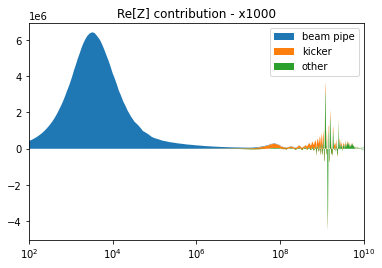

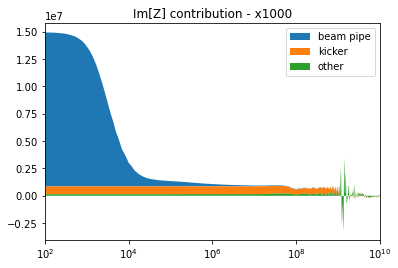

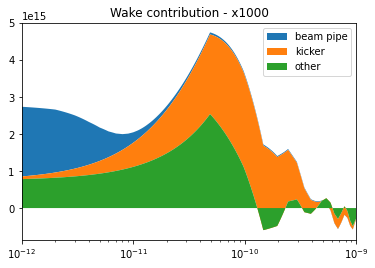

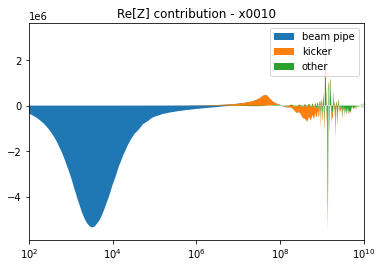

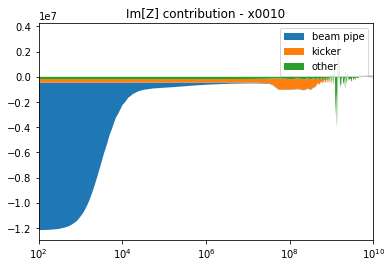

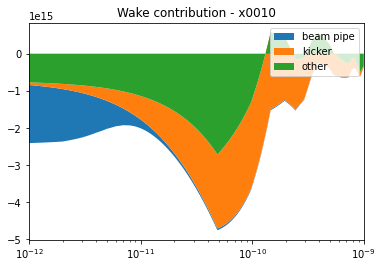

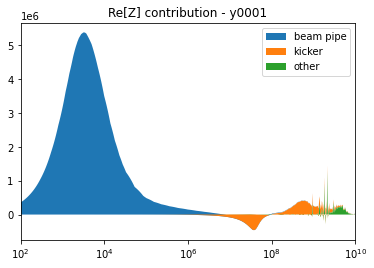

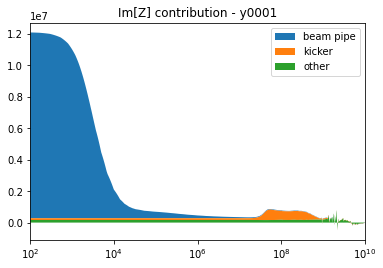

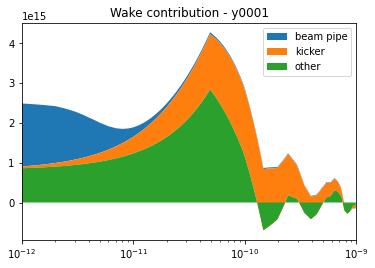

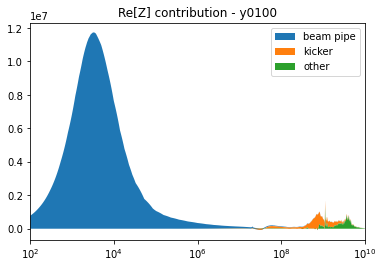

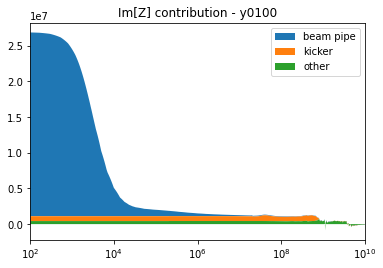

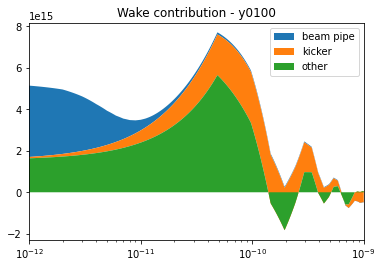

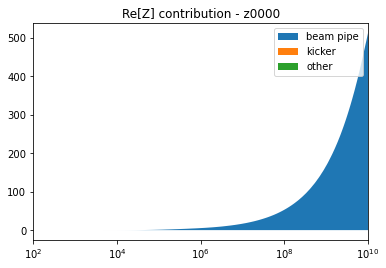

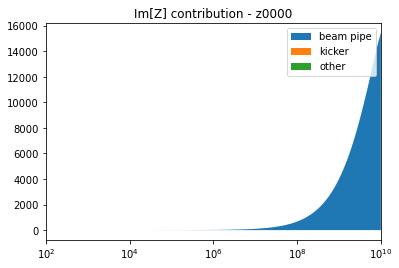

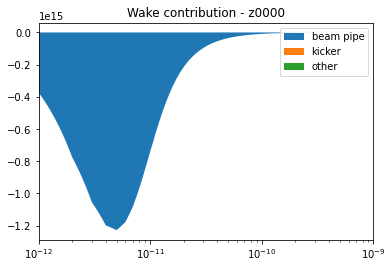

In [5]:
# Generates plots showing the contribution of each type of element (grouped by their tag) to the overall
# impedance and wake in each component, for each frequency/time
generate_contribution_plots(model, start_time=1e-12, stop_time=1e-9, start_freq=1e2, stop_freq=1e10, absolute=True)

# (The beam pipe element dominate the longitudinal components because we have only defined transverse components
# for the rest of the elements)

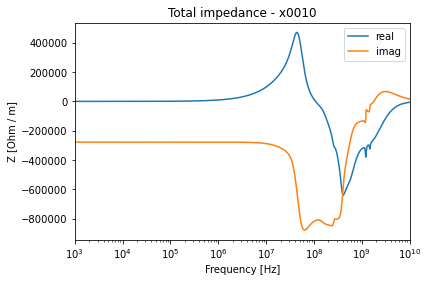

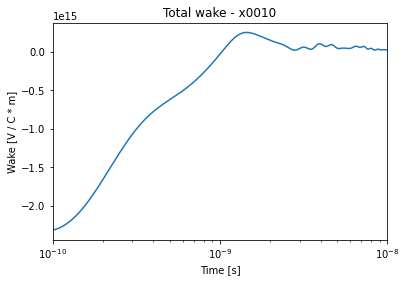

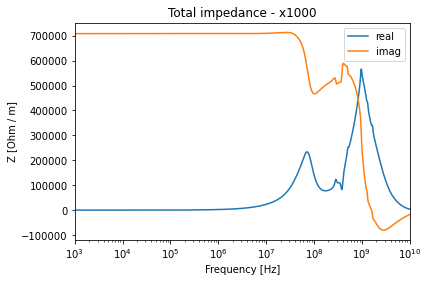

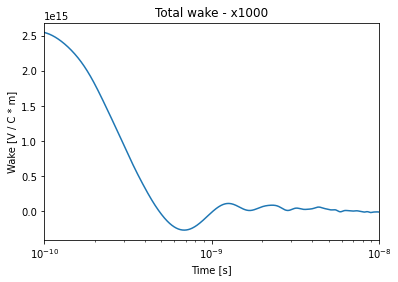

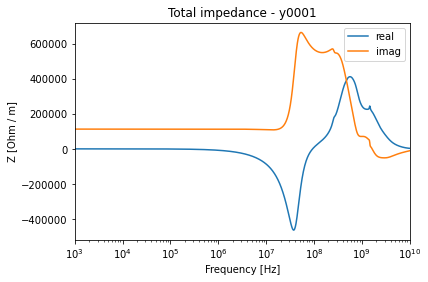

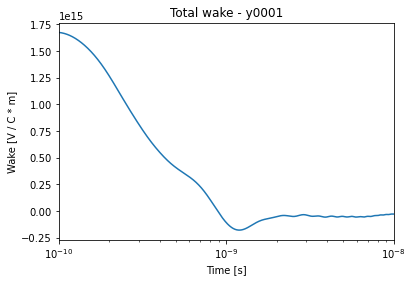

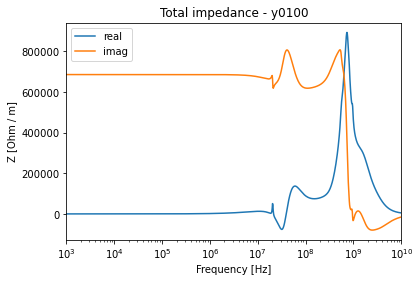

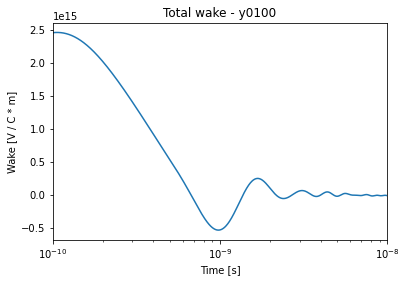

In [11]:
# We can extract just the kicker-elements from the model and plot their total impedance
kicker_elements = [e for e in model.elements if e.tag == 'kicker']
kicker_model = Model(kicker_elements, (default_beta_x, default_beta_y))
plot_total_impedance_and_wake(kicker_model, logscale_y=False, stop_time=1e-8)

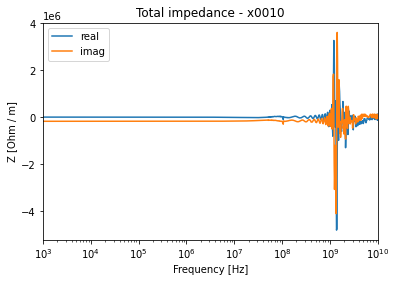

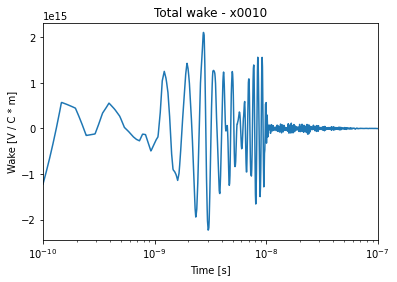

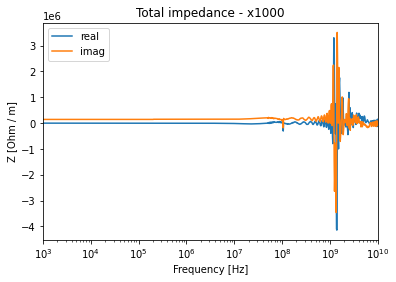

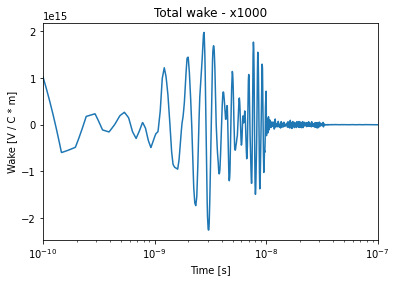

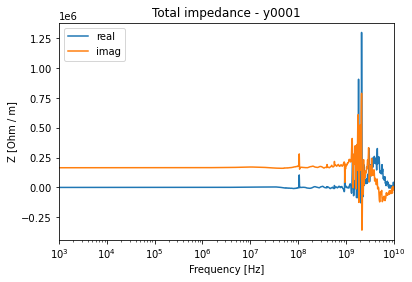

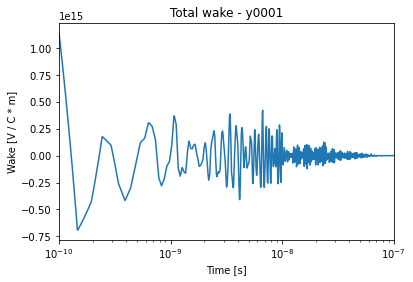

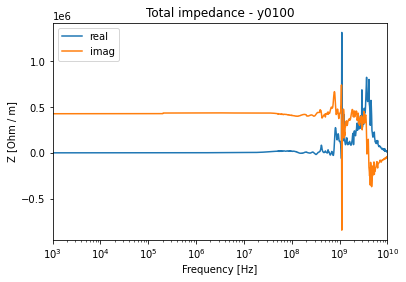

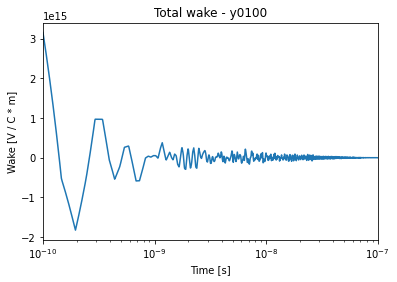

In [12]:
# We can extract just the 'other'-elements from the model and plot their total impedance
other_elements = [e for e in model.elements if e.tag == 'other']
other_model = Model(other_elements, (default_beta_x, default_beta_y))
plot_total_impedance_and_wake(other_model, logscale_y=False)

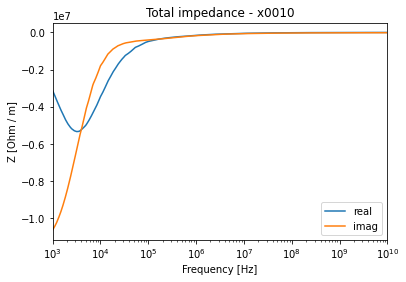

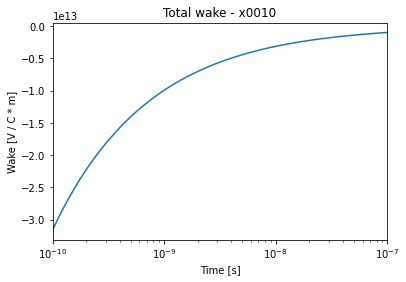

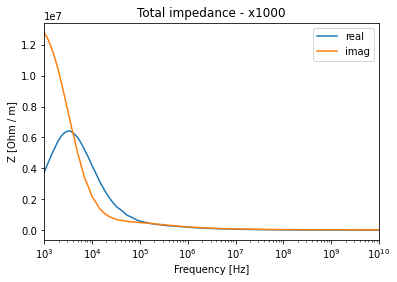

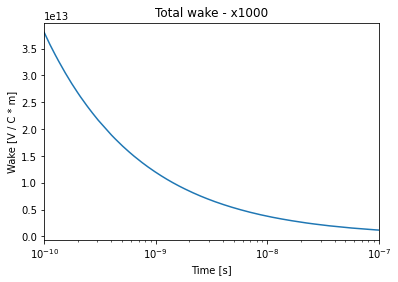

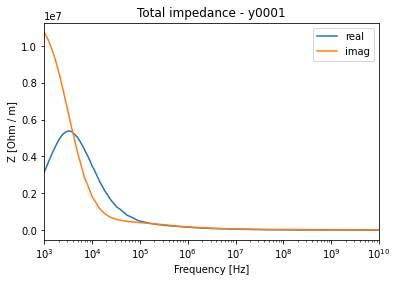

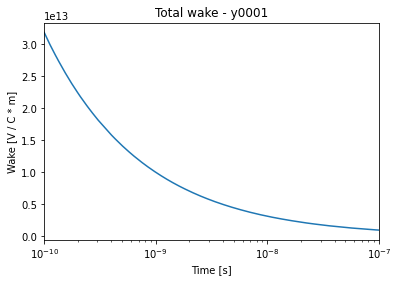

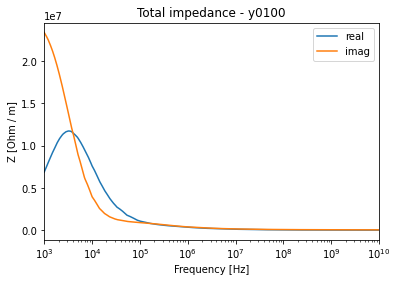

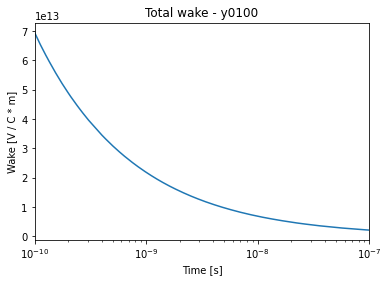

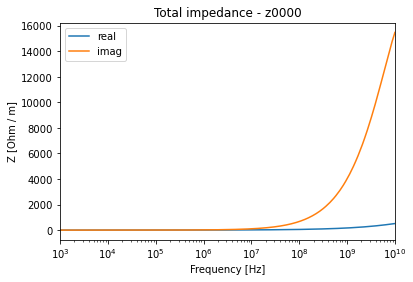

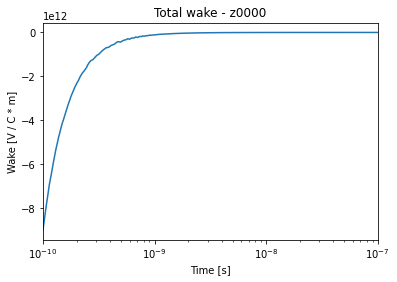

In [14]:
# We can extract just the beam pipe elements from the model and plot their total impedance
pipe_elements = [e for e in elements if e.tag == 'beam pipe']
pipe_model = Model(pipe_elements, (default_beta_x, default_beta_y))
plot_total_impedance_and_wake(pipe_model, logscale_y=False)

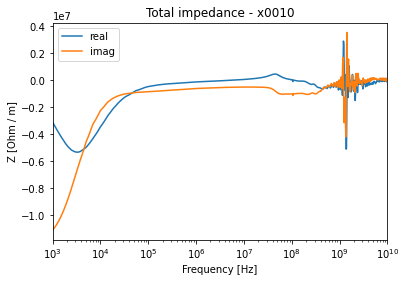

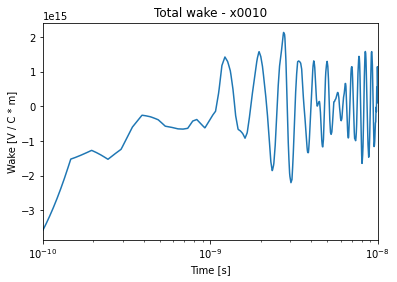

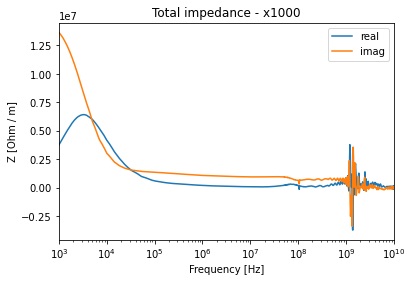

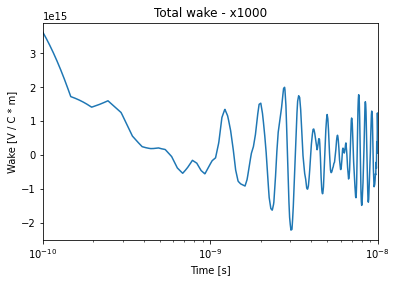

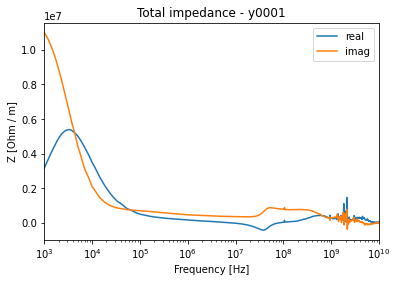

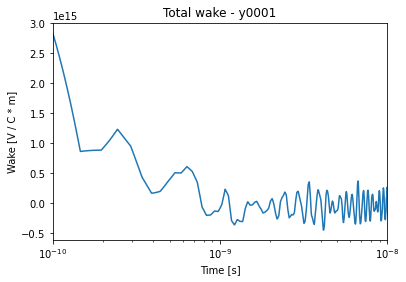

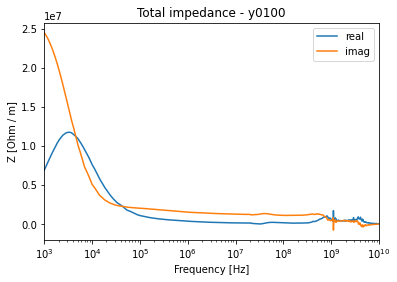

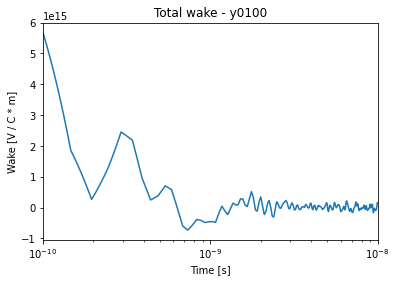

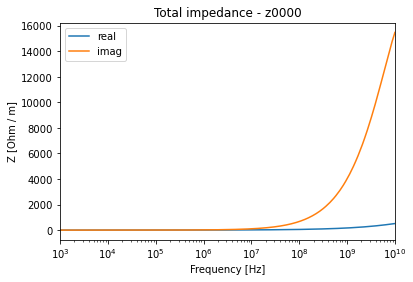

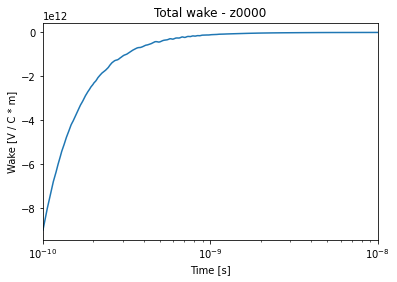

In [16]:
# We can plot the full impedance and wake of the full model
plot_total_impedance_and_wake(model, logscale_y=False, stop_time=1e-8)